# Data Import

### Google Cloud Storage

In [1]:
# !gsutil cp "gs://ca2_data/landmark.zip" "Data/landmark.zip"

In [2]:
# import zipfile
# with zipfile.ZipFile("Data/landmark.zip", 'r') as zip_ref:
#     zip_ref.extractall("Data/Train")

# Pre-Setup

## Fixed Part

In [3]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import os
from datetime import datetime


from sklearn.metrics import classification_report, confusion_matrix

# from keras_tqdm import TQDMNotebookCallback

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler,TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the TensorBoard notebook extension
%load_ext tensorboard

def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

# Base Folder (need to change according to the user)
# PROJECT_DIR = "/content/drive/My Drive/ISS/ISY5002 Pattern Recognition Systems/Project 2/Data"
# PROJECT_DIR = "/Users/jiahao/Google Drive/ISS/ISY5002 Pattern Recognition Systems/Project 2/Data"
# PROJECT_DIR = "Data"
PROJECT_DIR = r"C:\Users\joyce.li\Desktop\DL"


TRAIN_DIR = os.path.join(PROJECT_DIR, "Train")
VALIDATION_DIR = os.path.join(PROJECT_DIR, "Validation")
LOG_DIR = os.path.join(PROJECT_DIR, "Log")
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())

seed        = 29
np.random.seed(seed)

In [4]:
train_file_count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_file_count = sum([len(files) for r, d, files in os.walk(VALIDATION_DIR)])
print("Training images: ", train_file_count)
print("Validation images: ", test_file_count)

Training images:  2423
Validation images:  724


# Model Setup

## Basic Layer Define (Jen Hong Version)

In [5]:
# resLyr
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
    convLyr = Conv2D(numFilters,
                       kernel_size=kernelSz,
                       strides=strides,
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4),
                       name=lyrName+'_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
        x = convLyr(x)

    return x

# resBlkV1
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    x = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr = str(run+1)

        if downsampleOnFirst and run == 0:
            strides = 2

        y = resLyr(inputs=x,
                   numFilters=numFilters,
                   strides=strides,
                   lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y,
                   numFilters=numFilters,
                   activation=None,
                   lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x,
                        numFilters=numFilters,
                        kernelSz=1,
                        strides=strides,
                        activation=None,
                        batchNorm=False,
                        lyrName=names+'_Blk'+blkStr+'_lin' if names else None)
            
        x = add([x,y],name=names+'_Blk'+blkStr+'_add' if names else None)
        x = Activation('relu',name=names+'_Blk'+blkStr+'_relu' if names else None)(x)

    return x

## Learning Rate Define

In [6]:
def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 90:
        lr  *= 0.5e-3        
    elif epoch > 70:
        lr  *= 1e-3       
    elif epoch > 50:
        lr  *= 1e-2
    elif epoch > 30:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

## Model Parameters

In [7]:
img_rows = 16
img_cols = 16
epochs = 120
batch_size = 64

num_train_images=2423
num_test_samples = 724

optmz       = optimizers.Adam(lr=0.001)
modelname   = 'Model_2' 

LOG_DIR = os.path.join(PROJECT_DIR, modelname)

## Model Building

In [8]:
# createResNetV1
def createResNetV1(inputShape=(img_rows,img_cols,3),
                   numClasses=3):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, lyrName='Inpt')
    v = resBlkV1(v,16,3,False,'Stg1')
    v = resBlkV1(v,32,3,True,'Stg2')
    v = resBlkV1(v,64,3,True,'Stg3')
    # v = resBlkV1(v,128,3,True,'Stg4')
    v = AveragePooling2D(pool_size=4,name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numClasses,activation='softmax',kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                    optimizer=optmz,
                    metrics=['accuracy'])

    return model

# set up model
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

# model.summary()

## Checkpoint Define

In [9]:
# Create checkpoint for the training
# This checkpoint performs model saving when
# an epoch gives highest testing accuracy
filepath        = os.path.join(PROJECT_DIR, modelname + ".hdf5")
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

# Log the epoch detail into csv
csv_logger      = CSVLogger(os.path.join(PROJECT_DIR,  modelname +'.csv'))

# Tensorboard
tensorboard     = TensorBoard(log_dir=LOG_DIR,histogram_freq=1)
callbacks_list  = [checkpoint,csv_logger,LRScheduler,tensorboard]
# TQDMNotebookCallback(leave_inner=True),

## Image Data Generator Define

In [10]:
# version 0
# train_datagen = ImageDataGenerator(width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              rotation_range=20,
#                              horizontal_flip=True,
#                              vertical_flip=False)
# test_datagen = ImageDataGenerator()

# version 1
# train_datagen = ImageDataGenerator(rotation_range=40,
#                                     width_shift_range=0.2,
#                                     height_shift_range=0.2,
#                                     rescale=1./255,
#                                     shear_range=0.2,
#                                     zoom_range=0.2)
# test_datagen = ImageDataGenerator(rescale=1./255)

# version 2
train_datagen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2)
test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(VALIDATION_DIR,
                                                        target_size=(img_rows, img_cols), 
                                                        batch_size=batch_size, shuffle=False)

Found 2423 images belonging to 3 classes.
Found 724 images belonging to 3 classes.


In [11]:
# print(LOG_DIR)

In [12]:
# %tensorboard --logdir "/content/drive/My Drive/ISS/ISY5002 Pattern Recognition Systems/Project 2/Data/Log"
# %tensorboard --logdir "/Users/jiahao/Google Drive/ISS/ISY5002 Pattern Recognition Systems/Project 2/Data/Log"

# Model Training

## Fit Model 2

In [13]:
# train_datagen = ImageDataGenerator(rotation_range=40,
#                                     width_shift_range=0.2,
#                                     height_shift_range=0.2,
#                                     shear_range=0.2,
#                                     zoom_range=0.2)
# test_datagen = ImageDataGenerator()

# img_rows = 32
# img_cols = 32
# epochs = 40
# batch_size = 32

# num_train_images=2423
# num_test_samples = 724

# optmz       = optimizers.Adam(lr=0.001)
# modelname   = 'Model_2'

history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs, 
                    verbose=1,
                    workers=12,
                    steps_per_epoch=num_train_images//batch_size,
                    validation_steps=
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/120
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
37/37 [==============================] - 95s 3s/step - loss: 1.1122 - accuracy: 0.6117 - val_loss: 11.0489 - val_accuracy: 0.2887
Learning rate:  0.001
Epoch 2/120
37/37 [==============================] - 115s 3s/step - loss: 0.8720 - accuracy: 0.6905 - val_loss: 7.1036 - val_accuracy: 0.2928
Learning rate:  0.001
Epoch 3/120
37/37 [==============================] - 96s 3s/step - loss: 0.8113 - accuracy: 0.7219 - val_loss: 3.9765 - val_accuracy: 0.2901
Learning rate:  0.001
Epoch 4/120
37/37 [==============================] - 90s 2s/step - loss: 0.7959 - accuracy: 0.7287 - val_loss: 2.4546 - val_accuracy: 0.3743
Learning rate:  0.001
Epoch 5/120
37/37 [==============================] - 92s 2s/step - loss: 0.7555 - accuracy: 0.7435 - val_loss: 1.5191 - val_accuracy: 0.4931
Learning rate:  0.001
Epoch 6/120
37/37 [==============================] - 109s 3s/step -

37/37 [==============================] - 90s 2s/step - loss: 0.4029 - accuracy: 0.8961 - val_loss: 0.6381 - val_accuracy: 0.8066
Learning rate:  0.0001
Epoch 51/120
37/37 [==============================] - 95s 3s/step - loss: 0.4329 - accuracy: 0.8821 - val_loss: 0.6564 - val_accuracy: 0.7901
Learning rate:  1e-05
Epoch 52/120
37/37 [==============================] - 96s 3s/step - loss: 0.4170 - accuracy: 0.8940 - val_loss: 0.6521 - val_accuracy: 0.7914
Learning rate:  1e-05
Epoch 53/120
37/37 [==============================] - 93s 3s/step - loss: 0.3831 - accuracy: 0.9075 - val_loss: 0.6475 - val_accuracy: 0.7970
Learning rate:  1e-05
Epoch 54/120
37/37 [==============================] - 92s 2s/step - loss: 0.4150 - accuracy: 0.8915 - val_loss: 0.6490 - val_accuracy: 0.7956
Learning rate:  1e-05
Epoch 55/120
37/37 [==============================] - 92s 2s/step - loss: 0.4287 - accuracy: 0.8864 - val_loss: 0.6720 - val_accuracy: 0.7970
Learning rate:  1e-05
Epoch 56/120
37/37 [========

37/37 [==============================] - 92s 2s/step - loss: 0.4076 - accuracy: 0.8991 - val_loss: 0.6672 - val_accuracy: 0.7956
Learning rate:  1e-06
Epoch 76/120
37/37 [==============================] - 108s 3s/step - loss: 0.3974 - accuracy: 0.8953 - val_loss: 0.6969 - val_accuracy: 0.7956
Learning rate:  1e-06
Epoch 77/120
37/37 [==============================] - 93s 3s/step - loss: 0.3997 - accuracy: 0.8978 - val_loss: 0.6607 - val_accuracy: 0.7970
Learning rate:  1e-06
Epoch 78/120
37/37 [==============================] - 110s 3s/step - loss: 0.4041 - accuracy: 0.8957 - val_loss: 0.6773 - val_accuracy: 0.7956
Learning rate:  1e-06
Epoch 79/120
37/37 [==============================] - 108s 3s/step - loss: 0.4024 - accuracy: 0.8979 - val_loss: 0.6680 - val_accuracy: 0.7956
Learning rate:  1e-06
Epoch 80/120
37/37 [==============================] - 91s 2s/step - loss: 0.4139 - accuracy: 0.8953 - val_loss: 0.6669 - val_accuracy: 0.7956
Learning rate:  1e-06
Epoch 81/120
37/37 [======

Learning rate:  5e-07
Epoch 101/120
37/37 [==============================] - 92s 2s/step - loss: 0.4208 - accuracy: 0.8881 - val_loss: 0.6966 - val_accuracy: 0.7942
Learning rate:  5e-07
Epoch 102/120
37/37 [==============================] - 110s 3s/step - loss: 0.4154 - accuracy: 0.8966 - val_loss: 0.6675 - val_accuracy: 0.7928
Learning rate:  5e-07
Epoch 103/120
37/37 [==============================] - 109s 3s/step - loss: 0.3839 - accuracy: 0.9059 - val_loss: 0.6496 - val_accuracy: 0.7914
Learning rate:  5e-07
Epoch 104/120
37/37 [==============================] - 90s 2s/step - loss: 0.4044 - accuracy: 0.9000 - val_loss: 0.6500 - val_accuracy: 0.7914
Learning rate:  5e-07
Epoch 105/120
37/37 [==============================] - 91s 2s/step - loss: 0.4056 - accuracy: 0.8983 - val_loss: 0.6488 - val_accuracy: 0.7942
Learning rate:  5e-07
Epoch 106/120
37/37 [==============================] - 91s 2s/step - loss: 0.3722 - accuracy: 0.9113 - val_loss: 0.6474 - val_accuracy: 0.7942
Learning

# Evaluation

## Test 1

### Plot 1

In [20]:
list(history.history.keys())

['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr']

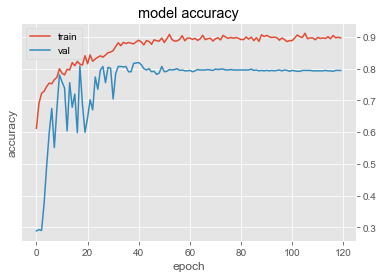

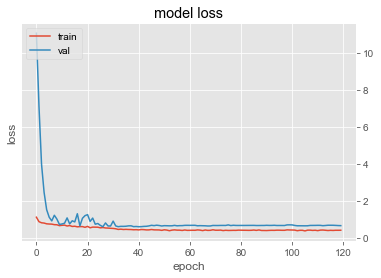

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Plot 2

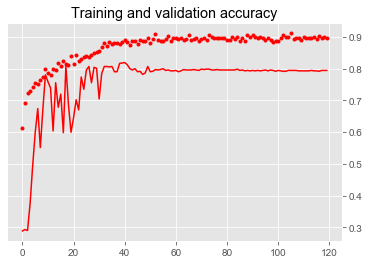

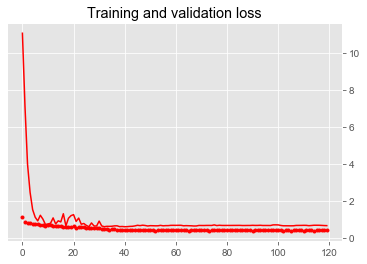

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

plot_training(history)
# print(dir(callbacks_list))

### Confusion Matrix

In [23]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, steps=np.math.ceil(validation_generator.samples/validation_generator.batch_size), verbose=1, workers=12)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 724 images belonging to 3 classes.
12/12 [==============================] - 24s 2s/step
Confusion Matrix
[[240  24  33]
 [ 19 161  38]
 [ 15  20 174]]
Classification Report
              precision    recall  f1-score   support

        food       0.88      0.81      0.84       297
    landmark       0.79      0.74      0.76       218
      people       0.71      0.83      0.77       209

    accuracy                           0.79       724
   macro avg       0.79      0.79      0.79       724
weighted avg       0.80      0.79      0.80       724



In [25]:
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        food       0.88      0.81      0.84       297
    landmark       0.79      0.74      0.76       218
      people       0.71      0.83      0.77       209

    accuracy                           0.79       724
   macro avg       0.79      0.79      0.79       724
weighted avg       0.80      0.79      0.80       724



In [26]:
print(os.path.join(PROJECT_DIR, modelname+'_model.png'))

C:\Users\joyce.li\Desktop\DL\Model_2_model.png


# Plot Model

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file=os.path.join(PROJECT_DIR, modelname+'_model.png'), 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

# VGG Model

In [ ]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model